<a href="https://colab.research.google.com/github/sanjanagarai/Stock-Market-Forecasting/blob/main/Stock_Market_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Important Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
data = pd.read_csv("/content/Combined_News_DJIA(train).csv")
stock_data = pd.read_csv("/content/Test_DJIA_Table.csv")

In [ ]:
# Initialize an empty list to store close values
close_values = []

# Iterate over the rows of stock_data in reverse order
for index, row in stock_data[::-1].iterrows():
    close_values.append(row['Adj Close'])

data['Close'] = close_values

## Data preprocessing

In [ ]:
# Check for NaN values in the dataset
print("Rows with NaN values before dropping:")
rows_with_nan_before = data[data.isnull().any(axis=1)]
print(rows_with_nan_before)

# Drop rows with NaN values
data.dropna(inplace=True)

# Print the row indices that are being dropped
print("Indices of rows being dropped:")
print(rows_with_nan_before.index)

Rows with NaN values before dropping:
           Date  Label                                               Top1  \
277  2009-09-15      1  b'The Church of Scientology won\'t be dissolve...   
348  2009-12-24      1  b'Woman knocks down Pope Benedict at Christmas...   
681  2011-04-21      1  Director of "Restrepo" and Photographer Chris ...   

                                                  Top2  \
277  b'New virus from rats can kill 80 per cent of ...   
348  b'Ugandan President Museveni says he will bloc...   
681  Everyone within 20km of Fukushima will be forc...   

                                                  Top3  \
277  b'The gruesome spectacle of dolphins being sla...   
348  b"Venezuela's Chavez threatens to kick out car...   
681  Bahrain: Activist Zaynab Al-Khawaja's letter t...   

                                                  Top4  \
277  b'The End of Innocence in Afghanistan: \'The G...   
348  b'Woman who knocked down pope had pasta in her...   
681  More tha

The rows with indices 277, 348 and 681 have been dropped

In [ ]:
# Define a function to preprocess strings
def preprocess_string(s):
    if isinstance(s, str):
        if s.startswith("b\"") or s.startswith("b'"):
            s = s[2:]
        if s.endswith('"') or s.endswith("'"):
            s = s[:-1]
    return s

# Apply the preprocessing function to the 'Top' columns
for col in data.columns:
    if col.startswith('Top'):
        data[col] = data[col].apply(preprocess_string)

In [ ]:
# Define a function to preprocess strings
def preprocess_string(s):
    if isinstance(s, str):
        if s.startswith("\"") or s.startswith("'"):
            s = s[1:]
        if s.endswith('"') or s.endswith("'"):
            s = s[:-1]
    return s

# Apply the preprocessing function to the 'Top' columns
for col in data.columns:
    if col.startswith('Top'):
        data[col] = data[col].apply(preprocess_string)

## Sentiment Analysis

We use VADER to determine the average compound score

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
# Initialize lists to store average sentiment scores for each day
avg_compound = []

# Iterate through each row of the DataFrame
for index, row in data.iterrows():
    com = 0

    # Iterate through the entries of columns 2 to 27 for this row
    for col in row[2:27]:
        # Calculate sentiment scores for each entry
        scores = sid.polarity_scores(col)
        com += scores['compound']

    # Divide pos, neg, and neu by 25 to get the average sentiment scores for each day
    avg_compound.append(com / 25)

# Add average sentiment scores to the DataFrame
data['avg_compound'] = avg_compound


We use TextBlob to determine the average polarity and subjectivity

In [ ]:
from textblob import TextBlob

In [ ]:
# Initialize lists to store average sentiment scores for each day
avg_sub = []
avg_pol = []

# Iterate through each row of the DataFrame
for index, row in data.iterrows():
    # Initialize variables to store sentiment scores for this row
    sub = 0
    pol = 0

    # Iterate through the entries of columns 2 to 27 for this row
    for col in row[2:27]:
        # Calculate sentiment scores for each entry
        blob = TextBlob(col)
        sub += blob.sentiment.subjectivity
        pol += blob.sentiment.polarity

    # Divide pos, neg, and neu by 25 to get the average sentiment scores for each day
    avg_sub.append(sub / 25)
    avg_pol.append(pol / 25)


# Add average sentiment scores to the DataFrame
data['avg_subjectivity'] = avg_sub
data['avg_polarity'] = avg_pol

In [ ]:
# Drop the columns named 'Top1' through 'Top25'
#data.drop(columns=['Top'+str(i) for i in range(1, 26)], inplace=True)

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

## Creating the test and train datasets

In [ ]:
df1 = data.reset_index()['Close']
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

train_close = df1
test_close = df1[1760:]

time_step = 100
X_train_close, y_train_close = create_dataset(train_close, time_step)
X_test_close, y_test_close = create_dataset(test_close, time_step)

In [ ]:
df2 = data.reset_index()['avg_compound']
df2 = np.array(df2).reshape(-1,1)

train_score = df2
test_score = df2[1760:]

time_step = 100
X_train_score, y_train_score = create_dataset(train_score, time_step)
X_test_score, y_test_score = create_dataset(test_score, time_step)

In [ ]:
df3 = data.reset_index()['avg_subjectivity']
df3 = np.array(df3).reshape(-1,1)

train_sub = df3
test_sub = df3[1760:]

time_step = 100
X_train_sub, y_train_sub = create_dataset(train_sub, time_step)
X_test_sub, y_test_sub = create_dataset(test_sub, time_step)

In [ ]:
df4 = data.reset_index()['avg_polarity']
df4 = np.array(df4).reshape(-1,1)

train_pol = df4
test_pol = df4[1760:]

time_step = 100
X_train_pol, y_train_pol = create_dataset(train_pol, time_step)
X_test_pol, y_test_pol = create_dataset(test_pol, time_step)

In [ ]:
df5 = data.reset_index()['Label']

train_label = df5
test_label = df5[1760:]

time_step = 100
X_train_label, y_train_label = create_dataset(train_close, time_step)
X_test_label, y_test_label = create_dataset(test_close, time_step)

In [ ]:
def concat(array1, array2, array3, array4, array5):
  li1 = array1.tolist()
  li2 = array2.tolist()
  endo=[]
  for i in range(len(li1)):
    final=[]
    for j in range(len(li1[0])):
      final.append([array1[i][j], array2[i][j], array3[i][j], array4[i][j], array5[i][j]])
    endo.append(final)
  return np.array(endo)



In [ ]:
X_train = concat(X_train_close, X_train_score, X_train_sub, X_train_pol, X_train_label)
X_test = concat(X_test_close, X_test_score, X_test_sub, X_test_pol, X_test_label)

In [ ]:
len(X_test)

126

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 5)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 5)

LSTM Model

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,5)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

## Training the model

In [ ]:
model.fit(X_train,y_train_close,validation_data=(X_test,y_test_close),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
59/59 [==============================] - 18s 189ms/step - loss: 0.0267 - val_loss: 0.0016
Epoch 2/100
59/59 [==============================] - 10s 169ms/step - loss: 7.8040e-04 - val_loss: 0.0015
Epoch 3/100
59/59 [==============================] - 11s 187ms/step - loss: 7.6820e-04 - val_loss: 0.0015
Epoch 4/100
59/59 [==============================] - 8s 134ms/step - loss: 7.3334e-04 - val_loss: 0.0014
Epoch 5/100
59/59 [==============================] - 10s 173ms/step - loss: 7.2936e-04 - val_loss: 0.0015
Epoch 6/100
59/59 [==============================] - 9s 147ms/step - loss: 7.9776e-04 - val_loss: 0.0013
Epoch 7/100
59/59 [==============================] - 8s 143ms/step - loss: 6.9380e-04 - val_loss: 0.0013
Epoch 8/100
59/59 [==============================] - 8s 129ms/step - loss: 8.0360e-04 - val_loss: 0.0012
Epoch 9/100
59/59 [==============================] - 9s 148ms/step - loss: 7.1858e-04 - val_loss: 0.0012
Epoch 10/100
59/59 [==============================] - 8

In [ ]:
test_pred = model.predict(X_test)
test_pred = scaler.inverse_transform(test_pred)
print(len(test_pred))


4/4 [==============================] - 1s 39ms/step
125


In [ ]:
final = data.reset_index()['Close']
test_tr = final[1860:]

In [ ]:
print(len(test_tr))

126


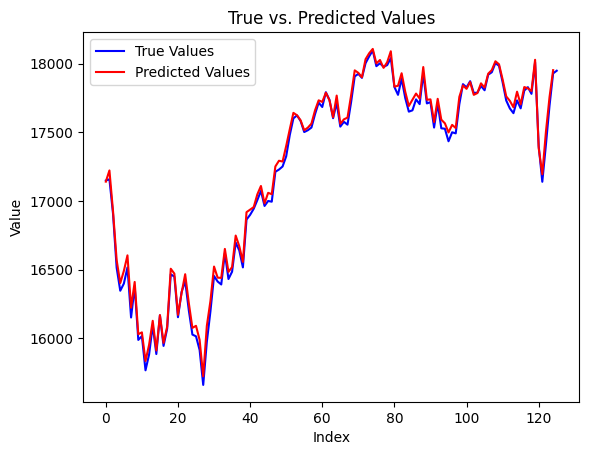

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'test_true' and 'test_predict' are your lists of true and predicted values

# Plot true values
plt.plot(test_tr, label='True Values', color='blue')

# Plot predicted values
plt.plot(test_pred, label='Predicted Values', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs. Predicted Values')

# Add legend
plt.legend()

# Show plot
plt.show()

In [ ]:
final_2 = data.reset_index()['Close']

In [ ]:
for i in range(125):
  print(test_tr[i], " ", test_pred[i])

17148.93945   [17141.16]
17158.66016   [17222.906]
16906.50977   [16925.332]
16514.09961   [16569.887]
16346.4502   [16401.959]
16398.57031   [16490.947]
16516.2207   [16604.168]
16151.41016   [16222.816]
16379.04981   [16410.469]
15988.08008   [16029.673]
16016.01953   [16043.01]
15766.74023   [15834.563]
15882.67969   [15953.297]
16093.50977   [16127.353]
15885.21973   [15910.687]
16167.23047   [16168.678]
15944.45996   [15966.191]
16069.63965   [16084.358]
16466.30078   [16506.738]
16449.17969   [16471.1]
16153.54004   [16170.864]
16336.66016   [16329.99]
16416.58008   [16466.738]
16204.96973   [16257.465]
16027.04981   [16075.681]
16014.37988   [16090.905]
15914.74023   [15988.341]
15660.17969   [15722.635]
15973.83984   [16089.908]
16196.41016   [16271.474]
16453.83008   [16522.705]
16413.42969   [16441.62]
16391.99023   [16440.088]
16620.66016   [16651.062]
16431.7793   [16483.805]
16484.99023   [16518.83]
16697.28906   [16748.48]
16639.9707   [16670.762]
16516.5   [16556.617]
16

In [ ]:
test_predictions = []
for i in range(126):
  test_predictions.append(test_pred[i][0] * 10**5)

In [ ]:
# Create a DataFrame with 'id' and 'close' columns
df = pd.DataFrame({'id': range(1, len(test_predictions) + 1), 'Close': test_predictions})

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)

In [ ]:
test_tr_scaled=[]
for i in range(126):
  test_tr_scaled.append(test_tr[i]*10**5)

Evaluation

In [ ]:
rmse = 0
for i in range(126):
  rmse = rmse + (test_tr_scaled[i] - test_predictions[i])**2
print(rmse/126)

18511224356178.066


In [ ]:
rmse = 0
for i in range(126):
  rmse = rmse + (test_tr_scaled[i] - answer[i])**2
print(rmse/126)

2.9743288913040476e+18
